# Predicting Mortality Rate Among Non-traumatic Intracerebral Haemorrhage Patients in Intensive Care Unit (ICU) Using MIMIC-IV Dataset

In this project, we will investigate the mortality rate of patients with non-traumatic intracerebral haemorrhage in the intensive care unit. We intend to compare the accuracy of mortality rate using three different classifiers, namely logistic regression, k-nearest neighbour, and random forest. 

Why is it critical to determine the mortality rate of patients with non-traumatic intracerebral haemorrhage? Stroke is a major health issue that affects people all over the world. Nontraumatic intracerebral haemorrhage (ICH) is a type of stroke in which a hematoma forms within the brain parenchyma, with or without blood extension into the ventricles (Rajashekar & Liang 2022). ICH affects over 2 million people each year and accounts for up to 10%–15% of all strokes (Cordonnier et al., 2018; Vilela & Wiesmann, 2020), with long-term morbidity and a high mortality rate when compared to other types of strokes (Tatlisumak et al., 2018). Carolei et al. (1997) and Van Asch et al. (2010) estimate that approximately 35% of ICH patients die within seven days, and approximately 50% die within 30 days. Furthermore, the global cost of caring for ICH patients, particularly those in intensive care units, is enormous (ICUs). As a result, it becomes critical to predict the mortality rate among ICH patients as early as possible.

ICH scores were previously used to determine mortality (Hemphill et al., 2001). The ICH score is calculated in the first minute of a patient's visit using the Glasgow Coma Scale (GCS), haemorrhage volume (cm3), intraventricular haemorrhage status, haemorrhage site (supra or infratentorial), and patient's age (Rahmani et al., 2018). The ICH score must be assessed by experienced radiologists and neurologists, which is expensive, time-consuming, and difficult for inexperienced users (Nie et al., 2021). APACHE II and SAPS II are reliable predictors of mortality in ICU patients (Lee et al., 2015; Godinjak et al., 2016). These scores use traditional statistical analysis to identify the most relevant covariates from preselected features, resulting in model oversimplification and discretization, reduced covariates, and poor model performance (Nie et al., 2021).

As a result of the limitations of the methods mentioned above, it is necessary to employ machine learning algorithms. The advantage of machine learning methods is that they allow for the automatic discovery of important variables and empirical patterns in data. It starts with the patient's observation and selects many variables to identify the combination that can predict the outcomes reliably. Machine learning can deal with variables with complex interactions using a variety of algorithms that do not make linear assumptions. Another advantage of machine learning is that it can process many predicted values, allowing for a more comprehensive and in-depth exploration of big data.


# About MIMIC dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Load the data 
# admissions = pd.read_csv('../data/core/admissions.csv')
patients = pd.read_csv('../data/core/patients.csv')
diagnose = pd.read_csv('../data/hosp/d_icd_diagnoses.csv')
subj_diagnose = pd.read_csv('../data/hosp/diagnoses_icd.csv')
vital_raw = pd.read_csv('../data/ed/vitalsign.csv')
icu_stays = pd.read_csv('../data/icu/icustays.csv')
item_names = pd.read_csv('../data/icu/d_items.csv').set_index('itemid')
chart_event = pd.read_csv('../data/icu/chart_event_filtered.csv')

MIMIC is a very large dataset, hence we only selected some part of it. We included the tables from four modules: `core`, `ed`, `hosp`, and `icu`. We will take a glance at these modules first.

## `core` module 

The core module stores patient tracking data for MIMIC-IV data analysis. The tables in this module list patient demographics, hospitalizations, and ward stays. 

The most important table is the `patients` table where the information that is consistent for the lifetime of a patient is stored. This will be used to identify each patient.

`dod` column (means "date of death") contains the information about mortality inside the hospital which will be used as target in this study.

In [3]:
patients.head(3)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,NaN
1,10002723,F,0,2128,2017 - 2019,NaN
2,10003939,M,0,2184,2008 - 2010,NaN


**describe**

## `hosp` module

The hospital module contains electronic health record data during hospitalisation. Since we foucsed on ICU patients in this analysis, most of the tables in this module is not of our interest. The only information we need is the billed diagnosis of patients in order to select our cohort.

`diagnoses_icd.csv` contains the icd code for each subject and the corresponding icd version. With the code and version we can acquire the name of the diagnoses from the `d_icd_diagnoses.csv` file. 

In [4]:
subj_diagnose.head(3)

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,15734973,20475282,3,2825,9
1,15734973,20475282,2,V0251,9
2,15734973,20475282,5,V270,9


In [5]:
diagnose.head(3)

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"


## `ed` module

`ed` module contains emergency room data. Each edstays row has a unique `stay id` representing a patient stay in the ED. If the patient was hospitalised after their ED visit, `hadm` (hospital addmision) id will be populated. hadm id can be linked to MIMIC-IV to get hospital stay details.  `subject id` can be linked to MIMIC-IV for patient demographics. 

We only use `vitalsign` table in this module since vitalsigns like heart rate, respotary rate are directly related to death. And the first set of vital signs after patients admitted to emergency room is most important since they haven't received any medication. 

In [6]:
vital_raw.head(3)

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,16113983,37539106,2116-06-10 00:32:00,98.2,82.0,15.0,NaN,106.0,72.0,NaN,NaN
1,15128994,30058281,2167-08-29 02:25:00,98.3,79.0,20.0,97.0,126.0,73.0,NaN,0
2,15128994,30058281,2167-08-29 04:51:00,97.6,79.0,20.0,98.0,126.0,73.0,NaN,0


## `icu` module

`icu` module contains the main data we are going to analyze. 

The `icu` data includes intravenous and fluid inputs, patient outputs, procedures, date/time information, and other charted information (chartevents). All events tables have a stay id column to identify ICU patients in icustays and an itemid column to identify concepts in d items.

`icustays.csv` tracks information for ICU stays including adminission and discharge times. This table will be used to identify the patients who were admitted to the icu since not all patients admitted to ICU. 

In [7]:
icu_stays.head(3)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454
1,14435996,28960964,31983544,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-19 17:57:00,2150-06-22 18:33:54,3.025625
2,17609946,27385897,33183475,Trauma SICU (TSICU),Trauma SICU (TSICU),2138-02-05 18:54:00,2138-02-15 12:42:05,9.741725


`chart_event_filtered.csv` contains the majority of the data. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The electronic chart displays patients’ routine vital signs and any additional information relevant to their care: ventilator settings, laboratory values, code status, mental status, and so on. Each event is represented by an `item_id` in this table and the real name of the event can be found in the `d_items.csv` file

`chart_event` table is fairly large, so we uploaded a filtered version. The code used for filtering were shown in appendix. 

In [8]:
chart_event.head(3)

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,Unnamed: 10
0,10006277,25610553,30888848,2176-06-08 01:18:00,2176-06-08 01:20:00,224876,Cloudy,0.0,NaN,NaN,NaN
1,10006277,25610553,30888848,2176-06-08 00:57:00,2176-06-08 01:00:00,223770,90,90.0,%,0.0,NaN
2,10006277,25610553,30888848,2176-06-08 04:18:00,2176-06-08 04:18:00,223988,Clear,0.0,NaN,NaN,NaN


In [9]:
item_names.head(3)

,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
itemid,,,,,,,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN


# The Cohort 
Here we select the patients dignosed with ICH from the whole hospital addmission. The corresponding ICD codes are 'I61*' (ICD-10) and '431*' (ICD-9). 

In [10]:
diagnose[diagnose['icd_code'].str.contains('I61')].head(3)

,icd_code,icd_version,long_title
24846,I61,10,Nontraumatic intracerebral hemorrhage
24847,I610,10,Nontraumatic intracerebral hemorrhage in hemis...
24848,I611,10,Nontraumatic intracerebral hemorrhage in hemis...


In [11]:
diagnose[diagnose['icd_code'].str.contains('^431')].head(3)

,icd_code,icd_version,long_title
4850,431,9,Intracerebral hemorrhage


Then we filter the patients who were addmitteed to the intensive care unit. 

In [12]:
icu_ids = icu_stays['subject_id'].unique()

In [13]:
def get_icu_cohort(icd10, icd9):
    """
    Input parameters are the icd code for a certain disease. For higher reliability, they should be regular expression. 
    """
    # filter all diagnosed subjects
    df1=patients.set_index('subject_id') 
    df_icd10=subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd10))]
    df_icd9 = subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd9))]
    df_icdall=pd.concat([df_icd9,df_icd10]).drop_duplicates('subject_id', keep='first')
    # filter the patients admitted to icu
    df_icu = df_icdall[df_icdall['subject_id'].isin(icu_ids)].set_index('subject_id')
    data = df_icu.join(df1,how='left')
    # add the target, i.e., mortality flag to the table
    data['dod']=data['dod'].replace(np.nan, 0, regex=True)
    data['dod']=data['dod'].replace('-', 1, regex=True)

    return data

def mortality_rate(df):
    """Calculate the mortality rate for selected cohort. """
    return np.count_nonzero(df['dod']==1)/len(df['dod'])

In [14]:
cohort = get_icu_cohort('I61',r'^431')
print('cohort size', cohort.shape[0])
print('mortality rate', mortality_rate(cohort))
cohort

cohort size 2485
mortality rate 0.2784708249496982


,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod
subject_id,,,,,,,,,
12116269,24214849,2,431,9,M,66,2166,2008 - 2010,0
12155595,26672436,2,431,9,F,52,2168,2008 - 2010,0
19620109,26497452,2,431,9,F,66,2128,2008 - 2010,0
19330004,20802265,1,431,9,M,52,2187,2008 - 2010,0
18414729,22609366,2,431,9,F,60,2152,2008 - 2010,0
...,...,...,...,...,...,...,...,...,...
14050724,20952526,1,I615,10,F,57,2112,2011 - 2013,0
12557389,21294125,1,I613,10,F,79,2151,2017 - 2019,0
18065731,25556934,1,I618,10,M,46,2137,2011 - 2013,0


**Describe Cohort  Figures**

# Feature Engineering

## Cohort Features

In [15]:
# drop unneccesary columns
cohort_final = cohort.drop(['hadm_id','seq_num','icd_code','icd_version','anchor_year_group'],axis=1)
cohort_final

,gender,anchor_age,anchor_year,dod
subject_id,,,,
12116269,M,66,2166,0
12155595,F,52,2168,0
19620109,F,66,2128,0
19330004,M,52,2187,0
18414729,F,60,2152,0
...,...,...,...,...
14050724,F,57,2112,0
12557389,F,79,2151,0
18065731,M,46,2137,0


In [16]:
from sklearn.preprocessing import LabelEncoder

# Covert gender to 0 and 1
lab_enc = LabelEncoder()
lab_enc.fit(cohort_final.gender)
cohort_final.gender = lab_enc.transform(cohort_final.gender)

# Convert the datatype of the target, i.e., the dod
cohort_final['dod'] = cohort_final['dod'].astype(np.int64)

In [17]:
print(cohort_final.dtypes)
cohort_final.head()

gender         int64
anchor_age     int64
anchor_year    int64
dod            int64
dtype: object


,gender,anchor_age,anchor_year,dod
subject_id,,,,
12116269,1,66,2166,0
12155595,0,52,2168,0
19620109,0,66,2128,0
19330004,1,52,2187,0
18414729,0,60,2152,0


In [18]:
# cohort subject id is used to select data from other tables.
cohort_ind = cohort.index
cohort_ind

Int64Index([12116269, 12155595, 19620109, 19330004, 18414729, 14731854,
            19513478, 14444370, 17759541, 11906321,
            ...
            12424554, 16078400, 17962961, 10445331, 16633337, 14050724,
            12557389, 18065731, 12853711, 17293846],
           dtype='int64', name='subject_id', length=2485)

## Vital Signs




In [19]:
# Drop rhythm, pain which have a lot of missing data
vital_signs = vital_raw[vital_raw['subject_id'].isin(cohort_ind)].iloc[:,:-2]
vital_signs.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
105,10046166,38848658,2132-12-06 11:53:00,97.0,75.0,12.0,NaN,154.0,73.0
261,10900387,30300312,2146-09-08 01:25:00,98.8,79.0,16.0,93.0,162.0,87.0
525,16652205,35474533,2169-04-09 18:55:00,NaN,73.0,27.0,98.0,169.0,79.0
526,16652205,35474533,2169-04-09 19:50:00,NaN,70.0,45.0,100.0,187.0,69.0
527,16652205,35474533,2169-04-09 21:00:00,98.4,70.0,30.0,98.0,138.0,58.0


In [22]:
vital_signs = vital_signs.drop_duplicates('subject_id', keep='last').set_index('subject_id')
vital_signs = vital_signs.drop(['stay_id','charttime'],axis=1)

In [23]:
vital_signs.head()

,temperature,heartrate,resprate,o2sat,sbp,dbp
subject_id,,,,,,
16652205,101.400000,100.0,44.0,97.551117,97.0,61.0
11213607,98.400000,98.0,20.0,98.000000,152.0,80.0
19620109,98.500000,67.0,15.0,100.000000,101.0,67.0
16379037,98.000000,100.0,19.0,98.000000,145.0,80.0
15936063,97.470476,118.0,20.0,98.000000,145.0,72.0


Not all participants have records in emergency room, so the missing values will be delt with later. 

## Chartted Event

In [24]:
chart_pivot= chart_event.pivot(index='subject_id', columns='itemid', values='value')
chart_pivot.head()

itemid,220045,220046,220047,220048,220179,220180,220181,220210,220228,220277,...,227443,227457,227465,227466,227467,227944,227968,227969,228096,228299
subject_id,,,,,,,,,,,,,,,,,,,,,
10006277,95,120,60,AF (Atrial Fibrillation),139,82,94,37,13,95,...,25,178,18.5,28.1,2,3 rails up,Yes,Bed locked in low position,NaN,NaN
10007677,84,130,50,SR (Sinus Rhythm),88,51,58,18,9.8,95,...,26,193,13.8,27.4,1.3,3 rails up,Yes,Pain evaluated and treated,0 Alert and calm,0 Alert and calm
10013310,100,130,50,ST (Sinus Tachycardia),116,61,84,19,8.8,100,...,27,290,12.8,27.6,1.3,3 rails up,Yes,Lines and tubes concealed,0 Alert and calm,0 Alert and calm
10017492,88,120,60,1st AV (First degree AV Block),149,63,71,25,8.4,98,...,23,357,11.1,23.7,1,3 rails up,Yes,Adequate lighting,0 Alert and calm,0 Alert and calm
10025463,81,120,60,ST (Sinus Tachycardia),122,81,91,22,NaN,97,...,NaN,NaN,NaN,NaN,NaN,3 rails up,Yes,Pain evaluated and treated,"-5 Unarousable, no response to voice or physic...","-2 Light sedation, briefly awakens to voice (e..."


In [25]:
def return_cat_index(cat):
    """
    Create an Index object for each kind of item. 
    """
    return fmeanings[fmeanings['param_type']==cat].index.to_list()

fmeanings = pd.read_csv('feature_meanings.csv').set_index('itemid')

num_index = return_cat_index('Numeric')
nom_index = return_cat_index('Nominal')
ord_index = return_cat_index('Ordinal')
bin_index = return_cat_index('Binary')

In [26]:
def fill_nan_class(index):
    """
    Fill the categorical variables in chart_pivot with 'itemid + untested'
    This function set the new values to the original dataframe.
    """
    for item in index:
        chart_pivot.loc[:,item] = chart_pivot[item].fillna((str(item)+'untested'))

In [20]:
def fill_nan_mean(df, rd=2):
    for col in list(df.columns[df.isnull().sum() > 0]):
        mean_val = df[col].mean()
        try:
            df[col]=df[col].fillna(mean_val)
        except TypeError:
            continue

In [27]:
# Fill the missing values in categorical variables
fill_nan_class(ord_index)
fill_nan_class(nom_index)
fill_nan_class(bin_index)
# Change the datatype for numeric variables and fill the missing values with overall mean.
chart_pivot[num_index] = chart_pivot[num_index].astype(np.float64)
fill_nan_mean(chart_pivot)

In [28]:
# check if everything is ok
chart_pivot[nom_index]

itemid,220048,223782,223783,223792,223795,223976,223979,223982,223983,223986,...,224650,224876,224879,226168,226732,227121,227240,227288,227343,227969
subject_id,,,,,,,,,,,,,,,,,,,,,
10006277,AF (Atrial Fibrillation),Constant,Back,Repositioned,Patient Verbalized,Normal,Normal,Normal,Normal,Clear,...,None,Cloudy,Patent,Swab,Nasal cannula,Brisk,Systolic,Brisk,Bed rest,Bed locked in low position
10007677,SR (Sinus Rhythm),Aching,Headache,IV Drip,223795untested,Normal,Normal,Normal,Normal,Clear,...,None,Clear,Patent,Swab,Nasal cannula,Brisk,Systolic,Brisk,Nurse assist,Pain evaluated and treated
10013310,ST (Sinus Tachycardia),None,Not Indicated,Repositioned,Non-verbal Cues,Normal,Normal,Normal,Normal,Diminished,...,None,Clear,Patent,Swab,None,Sluggish,Systolic,Brisk,Nurse assist,Lines and tubes concealed
10017492,1st AV (First degree AV Block),Intermittent,Right Hip,Repositioned,Non-verbal Cues,Normal,Normal,Normal,Normal,Clear,...,None,Clear,Patent,Swab,Non-rebreather,Brisk,Systolic,Brisk,Bed rest,Adequate lighting
10025463,ST (Sinus Tachycardia),223782untested,223783untested,223792untested,Change in Vitals,Normal,Normal,Normal,Normal,Clear,...,PVC's,Clear,Patent,Swab,Endotracheal tube,Non-reactive,Systolic,Sluggish,Bed rest,Pain evaluated and treated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992425,SB (Sinus Bradycardia),None,Not Indicated,Not applicable,Patient Verbalized,Normal,Normal,Normal,Normal,Clear,...,PAC's,Clear,Patent,Toothbrush (No observed alteration),Nasal cannula,Brisk,Systolic,Brisk,Nurse assist,Call light within reach
19992885,ST (Sinus Tachycardia),None,Not Indicated,IV Drip,Change in Vitals,Normal,Normal,Normal,Normal,Clear,...,None,Clear,Patent,Toothbrush (No observed alteration),Endotracheal tube,Sluggish,Systolic,Sluggish,Nurse assist,Bed locked in low position
19994233,AF (Atrial Fibrillation),None,Not Indicated,Backrub,Patient Verbalized,Normal,Normal,Normal,Normal,Clear,...,None,Clear,Patent,Oral Care Kit (Mild alteration),None,Brisk,Systolic,Brisk,Bed rest,Pain evaluated and treated


In [29]:
from sklearn.preprocessing import OrdinalEncoder

# Covert ordinal variables and binary variables into ordinal integers
ord_enc = OrdinalEncoder()
ord_enc.fit(chart_pivot[ord_index + bin_index])
chart_pivot[ord_index + bin_index] = ord_enc.transform(chart_pivot[ord_index + bin_index])


Before doing further analysis, we need to convert the remaining itemid into their names. This will make the one-hot encoding process easier to understand.

In [30]:
# Map from item id to their abbrvation
item_dict = dict()
for item_id in chart_pivot.columns:
    item_dict[item_id] = item_names.loc[item_id, 'abbreviation']

In [31]:
from operator import itemgetter

one_hot_encoded = pd.get_dummies(chart_pivot[nom_index],prefix=itemgetter(*nom_index)(item_dict))
one_hot_encoded.head()

,Heart Rhythm_1st AV (First degree AV Block),Heart Rhythm_220048untested,Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2),Heart Rhythm_A Flut (Atrial Flutter),Heart Rhythm_A Paced,Heart Rhythm_AF (Atrial Fibrillation),Heart Rhythm_AV Paced,Heart Rhythm_Asystole,Heart Rhythm_JR (Junctional Rhythm),Heart Rhythm_LBBB (Left Bundle Branch Block),...,Safety Measures_Medication offered,Safety Measures_Medication reviewed,Safety Measures_Mobility aides within reach,Safety Measures_Non-slip footwear provided,Safety Measures_Not applicable,Safety Measures_Oriented by RN,Safety Measures_Pain evaluated and treated,Safety Measures_Provided comfort with lines and tubes,Safety Measures_Provided distraction,"Safety Measures_Quiet, calm space"
subject_id,,,,,,,,,,,,,,,,,,,,,
10006277,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10007677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10013310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10017492,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10025463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [32]:
# combine the onehot encoded dataframe with the main dataframe
chart_final = chart_pivot.join(one_hot_encoded).drop(nom_index,axis=1)

In [33]:
chart_final.rename(columns=item_dict,inplace=True)
chart_final.head()

,HR,HR Alarm - High,HR Alarm - Low,NBPs,NBPd,NBPm,RR,Hemoglobin,SpO2,Hematocrit (serum),...,Safety Measures_Medication offered,Safety Measures_Medication reviewed,Safety Measures_Mobility aides within reach,Safety Measures_Non-slip footwear provided,Safety Measures_Not applicable,Safety Measures_Oriented by RN,Safety Measures_Pain evaluated and treated,Safety Measures_Provided comfort with lines and tubes,Safety Measures_Provided distraction,"Safety Measures_Quiet, calm space"
subject_id,,,,,,,,,,,,,,,,,,,,,
10006277,95.0,120.0,60.0,139.0,82.0,94.0,37.0,13.000000,95.0,40.500000,...,0,0,0,0,0,0,0,0,0,0
10007677,84.0,130.0,50.0,88.0,51.0,58.0,18.0,9.800000,95.0,28.700000,...,0,0,0,0,0,0,1,0,0,0
10013310,100.0,130.0,50.0,116.0,61.0,84.0,19.0,8.800000,100.0,28.700000,...,0,0,0,0,0,0,0,0,0,0
10017492,88.0,120.0,60.0,149.0,63.0,71.0,25.0,8.400000,98.0,29.200000,...,0,0,0,0,0,0,0,0,0,0
10025463,81.0,120.0,60.0,122.0,81.0,91.0,22.0,11.386364,97.0,34.335927,...,0,0,0,0,0,0,1,0,0,0


## Combine three tables

In [39]:
combined_df = cohort_final.join([vital_signs, chart_final])

In [40]:
fill_nan_mean(combined_df)
combined_df.head()

,gender,anchor_age,anchor_year,dod,temperature,heartrate,resprate,o2sat,sbp,dbp,...,Safety Measures_Medication offered,Safety Measures_Medication reviewed,Safety Measures_Mobility aides within reach,Safety Measures_Non-slip footwear provided,Safety Measures_Not applicable,Safety Measures_Oriented by RN,Safety Measures_Pain evaluated and treated,Safety Measures_Provided comfort with lines and tubes,Safety Measures_Provided distraction,"Safety Measures_Quiet, calm space"
subject_id,,,,,,,,,,,,,,,,,,,,,
12116269,1,66,2166,0,97.310377,79.834132,18.161347,97.575713,130.49386,74.035202,...,0,0,0,0,0,0,0,0,0,0
12155595,0,52,2168,0,97.310377,79.834132,18.161347,97.575713,130.49386,74.035202,...,0,0,0,0,0,0,0,0,0,0
19620109,0,66,2128,0,98.500000,67.000000,15.000000,100.000000,101.00000,67.000000,...,0,0,0,0,0,0,0,0,0,0
19330004,1,52,2187,0,97.600000,66.000000,16.000000,100.000000,166.00000,88.000000,...,0,0,0,0,0,0,0,0,0,0
18414729,0,60,2152,0,97.310377,79.834132,18.161347,97.575713,130.49386,74.035202,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

# Description

In [38]:
final

,gender,anchor_age,anchor_year,dod,temperature,heartrate,resprate,o2sat,sbp,dbp,...,Safety Measures_Medication offered,Safety Measures_Medication reviewed,Safety Measures_Mobility aides within reach,Safety Measures_Non-slip footwear provided,Safety Measures_Not applicable,Safety Measures_Oriented by RN,Safety Measures_Pain evaluated and treated,Safety Measures_Provided comfort with lines and tubes,Safety Measures_Provided distraction,"Safety Measures_Quiet, calm space"
subject_id,,,,,,,,,,,,,,,,,,,,,
12116269,1,66,2166,0,97.310377,79.834132,18.161347,97.575713,130.49386,74.035202,...,0,0,0,0,0,0,0,0,0,0
12155595,0,52,2168,0,97.310377,79.834132,18.161347,97.575713,130.49386,74.035202,...,0,0,0,0,0,0,0,0,0,0
19620109,0,66,2128,0,98.500000,67.000000,15.000000,100.000000,101.00000,67.000000,...,0,0,0,0,0,0,0,0,0,0
19330004,1,52,2187,0,97.600000,66.000000,16.000000,100.000000,166.00000,88.000000,...,0,0,0,0,0,0,0,0,0,0
18414729,0,60,2152,0,97.310377,79.834132,18.161347,97.575713,130.49386,74.035202,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14050724,0,57,2112,0,98.300000,69.000000,17.000000,100.000000,148.00000,76.000000,...,0,0,0,0,0,0,0,0,0,1
12557389,0,79,2151,0,97.470476,75.000000,23.000000,98.000000,119.00000,62.000000,...,0,0,0,0,0,1,0,0,0,0
18065731,1,46,2137,0,97.470476,87.000000,18.000000,97.551117,126.00000,75.000000,...,0,0,0,0,0,0,0,1,0,0


# Modelling

In [39]:
from DS_MIMIC_knn import train_test_split

In [42]:
combined_df[combined_df.dod==0].shape[0]/combined_df.shape[0]

0.7215291750503018

In [44]:
y = combined_df.pop('dod')


In [47]:
X = combined_df


In [58]:
X.shape

(2485, 569)

In [61]:
 np.random.rand(X.shape[0])

array([0.24642334, 0.39159819, 0.58673503, ..., 0.54293205, 0.11523535,
       0.65676832])

In [62]:
def train_test_split(X, y,train_size):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < train_size
    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test =  y[~split]
    return X_train, X_test,y_train, y_test

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y,0.8)
std= StandardScaler()
X_train=std.fit_transform(X_train_orig)
X_test=std.fit_transform(X_test_orig)

In [72]:
X_train = X_train_orig
X_test = X_test_orig

X_train.shape,X_test.shape

((1986, 569), (499, 569))

## Logistic Regression

In [73]:
# check classification scores of logistic regression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.862
LogisticRegression log_loss is 0.356
LogisticRegression auc is 0.889


/home/jzni/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/tmp/ipykernel_19443/4273864042.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
/tmp/ipykernel_19443/4273864042.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')


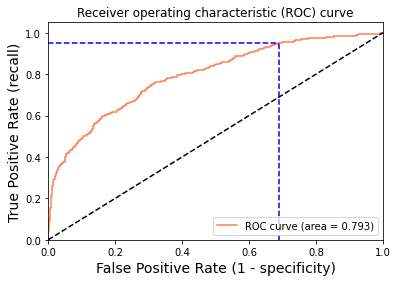

Using a threshold of 0.001 guarantees a sensitivity of 0.950 and a specificity of 0.312, i.e. a false positive rate of 68.79%.


In [68]:
idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

## Random Forest

In [74]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Fit the model
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train_orig, y_train)

# Use score method to calculate the accuracy over the whole test set
acc=rf.score(X_test_orig, y_test)
print(acc)
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X, y)


ft_imp = pd.Series(rf.feature_importances_).sort_values(ascending=False)
ft_imp.head(10)
ft_imp

0.8356713426853707


25     0.071895
35     0.057530
531    0.052493
95     0.045868
539    0.028254
         ...   
210    0.000000
416    0.000000
211    0.000000
157    0.000000
399    0.000000
Length: 569, dtype: float64

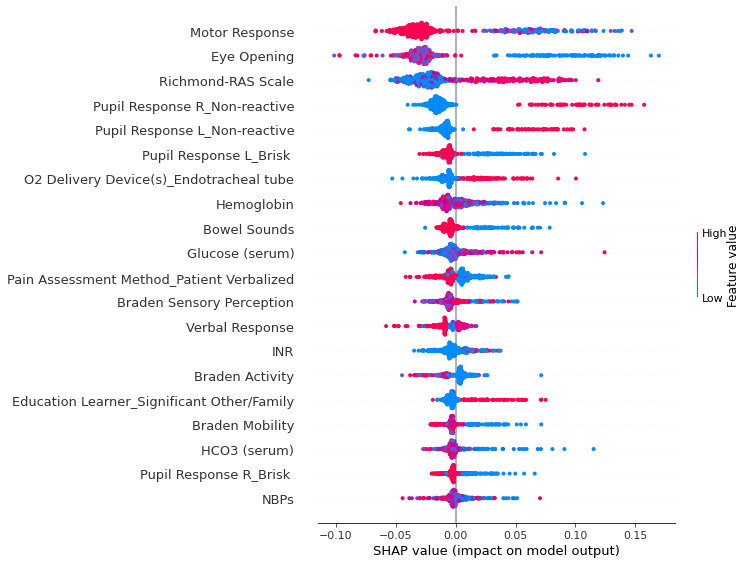

In [75]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_orig)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test_orig)

## KNN

In [76]:
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(40)
test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))


In [77]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [78]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 74.14829659318637 % and k = [6]


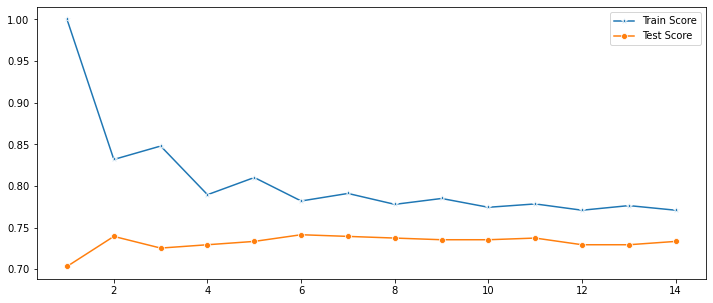

In [79]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,15),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,15),y=test_scores,marker='o',label='Test Score')

## My KNN


In [80]:
def My_knncomper_difftest(kmax):
    rightnumber = 0           
    print('enter phase 2')
    Train_acc=[]
    Test_acc=[]  
    print(" maximum K value is "+str(kmax))           
    for k in range(1,kmax):
        test_predict_score=0
        rightnumber=0
        predictlist =MYknn(X_test_std, X_train_std, Y_train, k)
        for m in range(len(X_test_std)):
            if predictlist[m] == Y_test[m]:
                rightnumber = rightnumber + 1
        test_predict_score = (rightnumber / len(Y_test))
#         print(test_predict_score*100)
        Test_acc.append(  test_predict_score * 100)
        rightnumber=0
        Train_predict_score=0
        predictlist = MYknn(X_train_std, X_train_std, Y_train, k)
        for m in range(len(X_train_std)):
            if predictlist[m] == Y_train[m]:
                rightnumber = rightnumber + 1
        Train_predict_score = (rightnumber / len(X_train_std))
        Train_acc.append( Train_predict_score * 100)      
     
    plt.plot(Test_acc)
    plt.title('Test_acc')
    plt.show()
    plt.plot(Train_acc)
    plt.title('Train_acc')
    plt.show()

        
def MYknn(test_object, training_object, training_object_target, K):
    predictlist = []
    for newpoint in test_object:
        dataSetSize = training_object.shape[0]
        # caculate the distance matrix between new point and all training  points 
        diffMat= np.tile(newpoint, (dataSetSize, 1)) - training_object
        sqDistances = (diffMat**2).sum(axis=1)
        distances = sqDistances ** 0.5
        # argsort: sort array and return array index,keep the orignal array.
        sortedDistIndicies = distances.argsort()
        classCount = {}
        
        for i in range(K):
            # get lables form 0 to k nearest training points
            voteIlabel = training_object_target[sortedDistIndicies[i]]
            #Count different lables number 
            classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1  
            # sort lable and get the most lable
            sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
        # store predict newpoint label 
        predictlist.append(sortedClassCount[0][0])
    return predictlist




In [53]:
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt

In [54]:
MIMIC_Y = MIMIC_Data.pop('dod').values
MIMIC_X = MIMIC_Data.values

In [82]:

np.random.seed(40)
# X_train, X_test, Y_train, Y_test= train_test_split(MIMIC_X, MIMIC_Y,train_size=70)
X_train_std=(X_train_orig-X_train_orig.mean())/X_train.std()
X_test_std=(X_test_orig-X_test_orig.mean())/X_test.std()
print('use my knn')

My_knncomper_difftest(20)

use my knn
enter phase 2
 maximum K value is 20


NameError: name 'Y_train' is not defined

# Appendix

We select chart event data from Google Bigquery using SQL. This command took about 20 mins to run, and returns milions of rows of data.
So won't run it in the notebook, we filtered the data and saved it locally. 

In [ ]:
for i in range(5):
    sql = f"""SELECT * 
    FROM `physionet-data.mimic_icu.chartevents`
    WHERE subject_id in {tuple(cohort.index[497*i:497*(i+1)].values.tolist())}
    ORDER BY subject_id"""

    df = pd.read_gbq(sql, project_id='focus-dragon-313813', dialect='standard', use_bqstorage_api=True)
    df.to_csv(f'df{i}.csv')